In [223]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

[ 0  1 10 11 12 13 14]
[0 1 2 3 4 5 6]
(83, 86)


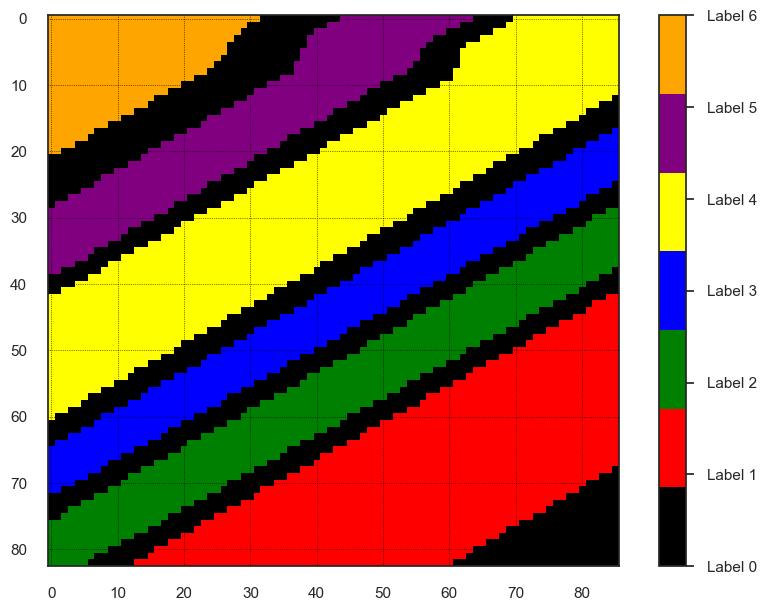

[[6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]


In [224]:
import scipy.io

# Load .mat file
SalinasA= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA.mat')['salinasA'])
SalinasA_corrected= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_corrected.mat')['salinasA_corrected'])
SalinasA_gt= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_gt.mat')['salinasA_gt'])

i=0
label_data = [0,6,1,5,4,3,2]
print(np.unique(SalinasA_gt))
for ele in np.unique(SalinasA_gt):
    #print(ele)
    mask = SalinasA_gt==ele
    SalinasA_gt[mask] = label_data[i]
    #print(SalinasA_gt)
    i=i+1
    #print(i+1)
print(np.unique(SalinasA_gt))

print(SalinasA_gt.shape)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Define a colormap with colors for each label
colors = ['black', 'red', 'green', 'blue', 'yellow', 'purple', 'orange']
cmap = ListedColormap(colors)

plt.imshow(SalinasA_gt, cmap=cmap, vmin=0, vmax=len(colors)-1)

# Add colorbar to show label-color mapping
cbar = plt.colorbar(ticks=np.arange(len(colors)))
cbar.set_ticklabels([f'Label {i}' for i in range(len(colors))])
# Add a label at a specific coordinate (e.g., x=5, y=5)
#label_text = "A"
#plt.text(20, 10, label_text, color='red', fontsize=4, ha='center', va='center')
# Set ticks to align with individual pixels
#plt.xticks(np.arange(0.0, 87.0, 1), [])
#plt.yticks(np.arange(0.0, 84.0, 1), [])
plt.grid(True, which='both', color='black', linewidth=0.5, linestyle=':')
plt.show()
print(SalinasA_gt)

In [225]:
SalinasA_gt.shape, SalinasA_corrected.shape

((83, 86), (83, 86, 204))

In [226]:
import pandas as pd 
######################################################################
## Arrange Data as concatationation of spacial co-ordinate and pixel values
###########################################################################
H, W = SalinasA_gt.shape # get the shape of groud truth
n_features = SalinasA_corrected.shape[2]+4 # get the number of features including co-ordinates and label

# Create a dataset which has "X","Y","Z", "Label", and spectral channel information
data_hsi = torch.zeros((H*W, n_features ))
for i in range(H):
    for j in range(W):
        data_hsi[i*W+j,0] = j
        data_hsi[i*W +j,2] = - i
        data_hsi[i*W +j,3] = SalinasA_gt[i,j]
        data_hsi[i*W +j,4:] = torch.tensor(SalinasA_corrected[i,j,:])
# Create a list of column name
column_name=["X","Y","Z", "Label"]
for i in range(SalinasA_corrected.shape[2]):
        column_name.append("feature_"+str(i+1))
        
# Create a pandas dataframe to store the database
df_hsi = pd.DataFrame(data_hsi,columns=column_name)
 # Create a database by removing the non labelled pixel information 
df_with_non_labelled_pixel = df_hsi.loc[(df_hsi['Label']!=0)]

# Normalise along the spectral lines 
df_with_spectral_normalised = df_with_non_labelled_pixel
df_with_spectral_normalised.iloc[:, 4:] = df_with_spectral_normalised.iloc[:, 4:].apply(zscore,axis=1)

###########################################################################
## Obtain the preprocessed data
###########################################################################
normalised_data = df_with_spectral_normalised.loc[(df_with_spectral_normalised["X"]>=19)&(df_with_spectral_normalised["X"]<=21)]
normalised_hsi =torch.tensor(normalised_data.iloc[:,4:].to_numpy(), dtype=torch.float64)
y_obs_label = torch.tensor(normalised_data.iloc[:,3].to_numpy(), dtype=torch.float64)

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_12213/4146256750.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_spectral_normalised.iloc[:, 4:] = df_with_spectral_normalised.iloc[:, 4:].apply(zscore,axis=1)


In [227]:
# data_= df_hsi.loc[(df_hsi["Label"]!=0) &(df_hsi["X"]==20)]
# data_.iloc[:, 4:] = data_.iloc[:, 4:].apply(zscore,axis=1)
# data_

In [228]:
#df_with_non_labelled_pixel = df_hsi.loc[df_hsi['Label']!=0]
#df_with_non_labelled_pixel

In [229]:
#df_with_x_20 = df_with_non_labelled_pixel.loc[df_with_non_labelled_pixel["X"]==20]
#df_with_x_20

In [230]:
# Normalise along the spectral lines 
# df_with_spectral_normalised = df_with_non_labelled_pixel
# df_with_spectral_normalised.iloc[:, 4:] = df_with_spectral_normalised.iloc[:, 4:].apply(zscore,axis=1)

In [231]:
#df_with_spectral_normalised.loc[df_with_spectral_normalised["X"]==20]

In [232]:
# column = 20
# y_obs = torch.tensor(SalinasA_gt[:,column], dtype=torch.float64)
# #print(y_obs, y_obs.shape)
# mask = y_obs!=0
# #print(mask)
# y_obs_label = y_obs[mask]
# #print(y_obs_label)
# #print(SalinasA_corrected.shape)
# y_obs_hsi = torch.tensor(SalinasA_corrected[:,column,:], dtype=torch.float64)[mask]
# y_obs_hsi.shape

In [233]:
#y_obs_hsi

In [234]:
# df = df_with_spectral_normalised.loc[df_with_spectral_normalised["X"]==20]
# df

In [235]:
# normalised_hsi = zscore(y_obs_hsi, axis=1)
# normalised_hsi

In [236]:
normalised_hsi.shape

torch.Size([180, 204])

In [237]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
transformed_hsi = model.fit_transform(normalised_hsi) 

In [238]:
transformed_hsi.shape

(180, 2)

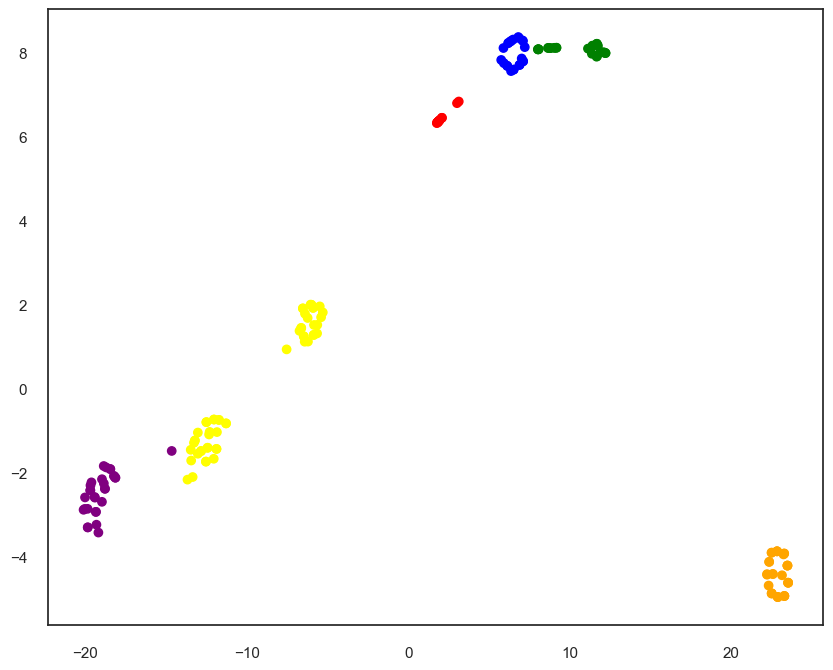

In [239]:
plt.figure(figsize=(10,8))
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=y_obs_label, cmap=ListedColormap(colors[1:]))


In [240]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [241]:
gm =gm = BayesianGaussianMixture(n_components=6, random_state=0).fit(normalised_hsi)


In [242]:
gm.means_ , gm.covariances_

(array([[-0.95512338, -0.83651873, -0.57239618, ..., -1.32936182,
         -1.37114101, -1.3573797 ],
        [-0.56205505, -0.49757152, -0.4172003 , ..., -0.75109011,
         -0.75273255, -0.75189381],
        [-0.85842159, -0.73563414, -0.5527217 , ..., -1.16403794,
         -1.1906859 , -1.18238296],
        [-0.9180157 , -0.83817159, -0.60683496, ..., -1.25041474,
         -1.27272153, -1.26590868],
        [-0.75506681, -0.67611533, -0.51965794, ..., -1.00395631,
         -1.01948105, -1.01306772],
        [-0.95525904, -0.82532206, -0.56252933, ..., -1.33793857,
         -1.38012147, -1.36632978]]),
 array([[[ 6.15957078e-04,  2.90582329e-04,  1.02803680e-04, ...,
           2.37107552e-04,  2.44775804e-04,  2.49863572e-04],
         [ 2.90582329e-04,  6.08078329e-04,  1.15314637e-04, ...,
           2.03816734e-04,  1.96897743e-04,  2.02233834e-04],
         [ 1.02803680e-04,  1.15314637e-04,  1.61115164e-04, ...,
           8.74016154e-05,  9.35559486e-05,  9.40005797e-05],
  

In [243]:
gmm_label = gm.predict(normalised_hsi) +1 
gmm_label

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4])

In [244]:
y_obs_label

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)

In [245]:
gmm_label2 = torch.zeros_like(y_obs_label)
gmm_label2[gmm_label==2]=6
gmm_label2[gmm_label==4]=1
gmm_label2[gmm_label==1]=4
gmm_label2[gmm_label==3]=3
gmm_label2[gmm_label==6]=5
gmm_label2[gmm_label==5]=2
gmm_label2

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2.,
        2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)

In [246]:
gm.means_.shape

(6, 204)

In [247]:
gmm_label2 - y_obs_label

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [248]:
# Find the correct rearrangement
rearrange_list = [3,4,2,0,5,1]
mean_init, cov_init = gm.means_[rearrange_list], gm.covariances_[rearrange_list]
mean_init.shape, cov_init.shape

((6, 204), (6, 204, 204))

In [249]:
abs_error = torch.sum(torch.abs(y_obs_label - gmm_label2))/ len(gmm_label2) *100
abs_error

tensor(22.7778, dtype=torch.float64)

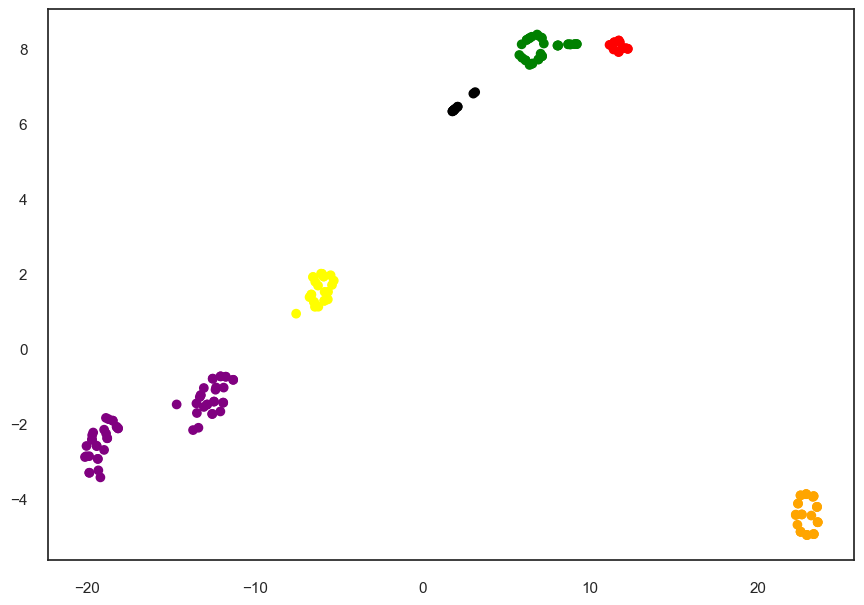

In [250]:
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=gmm_label2,cmap=ListedColormap(colors))

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


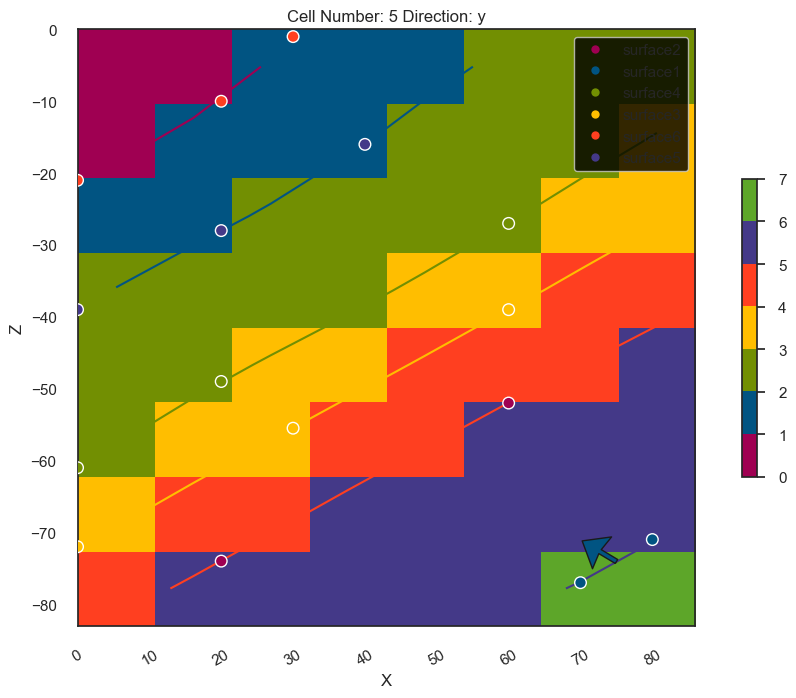

In [251]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([-74, -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, -49, -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, -28, -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, -10, -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element6)

geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1],\
geo_model_test.structural_frame.structural_groups[0].elements[2], geo_model_test.structural_frame.structural_groups[0].elements[3],\
geo_model_test.structural_frame.structural_groups[0].elements[4], geo_model_test.structural_frame.structural_groups[0].elements[5] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0],\
geo_model_test.structural_frame.structural_groups[0].elements[3], geo_model_test.structural_frame.structural_groups[0].elements[2],\
geo_model_test.structural_frame.structural_groups[0].elements[5], geo_model_test.structural_frame.structural_groups[0].elements[4]  

gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')


gempy_viewer.modules.plot_2d.visualization_2d.Plot2D

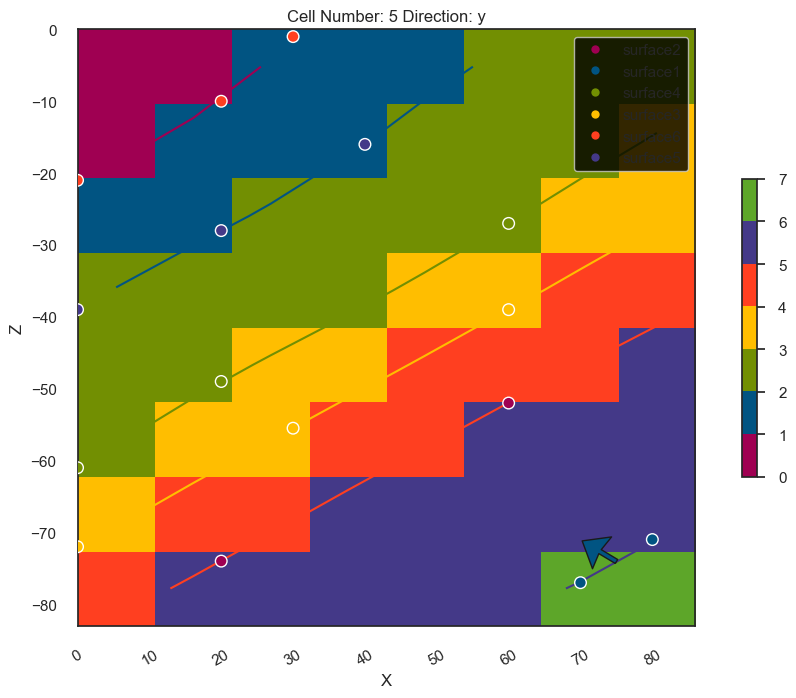

In [252]:
picture_test = gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
#plt.savefig("test.png")
type(picture_test)

In [253]:
y_obs_label = 7 -y_obs_label
y_obs_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       dtype=torch.float64)

In [254]:
# x_loc = 20
# y_loc = 0
# z_loc = np.linspace(0,-82, 83)
# print(z_loc)
# xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])[mask]
# print(xyz_coord.shape)
xyz_coord = normalised_data.iloc[:,:3].to_numpy()
print(xyz_coord.shape)
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

(180, 3)
Active grids: ['custom']


In [255]:
geo_model_test.interpolation_options.mesh_extraction = False
sol = gp.compute_model(geo_model_test)

Setting Backend To: AvailableBackends.numpy


In [256]:
#gpv.plot_2d(geo_model_test, section_names=['section1'])

In [257]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [258]:
geo_model_test.surface_points

X,Y,Z,id,nugget
20.00,0.00,-74.00,28678632,0.00
60.00,0.00,-52.00,28678632,0.00
70.00,0.00,-77.00,97420801,0.00
80.00,0.00,-71.00,97420801,0.00
0.00,0.00,-61.00,28249168,0.00
20.00,0.00,-49.00,28249168,0.00
60.00,0.00,-27.00,28249168,0.00
0.00,0.00,-72.00,49422017,0.00
30.00,0.00,-55.50,49422017,0.00
60.00,0.00,-39.00,49422017,0.00


Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


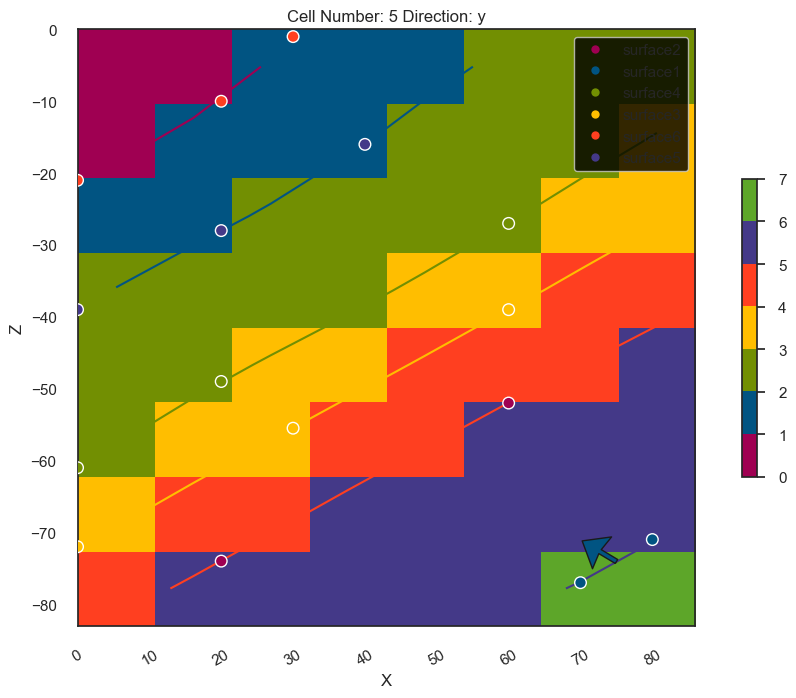

In [259]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [260]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [261]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [262]:
# geo_model_test.interpolation_options.uni_degree = 0
# geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 50

In [263]:
geo_model_test.solutions.octrees_output[0].last_output_center

InterpOutput(scalar_fields=ScalarFieldOutput(weights=array([-1.58450258e+00,  4.26719835e-17, -9.07995259e-01,  1.47537823e-02,
       -1.63896301e+00,  7.34936835e-02, -4.24866590e-03, -5.30118658e-02,
        5.72069162e-03, -1.48519490e-01,  1.22845313e-01,  4.64191770e-02,
       -4.14558661e-02, -7.47661279e-01, -2.00597546e-16,  1.31611094e+00]), grid=Grid(regular_grid=RegularGrid(extent=array([-3.749999,  0.550001, -0.499999,  0.500001, -0.449999,  3.700001]), regular_grid_shape=array([2, 2, 2])), custom_grid=GenericGrid(values=array([[-2.8 ,  0.  ,  3.7 ],
       [-2.75,  0.  ,  3.7 ],
       [-2.7 ,  0.  ,  3.7 ],
       [-2.8 ,  0.  ,  3.65],
       [-2.75,  0.  ,  3.65],
       [-2.7 ,  0.  ,  3.65],
       [-2.8 ,  0.  ,  3.6 ],
       [-2.75,  0.  ,  3.6 ],
       [-2.7 ,  0.  ,  3.6 ],
       [-2.8 ,  0.  ,  3.55],
       [-2.75,  0.  ,  3.55],
       [-2.7 ,  0.  ,  3.55],
       [-2.8 ,  0.  ,  3.5 ],
       [-2.75,  0.  ,  3.5 ],
       [-2.7 ,  0.  ,  3.5 ],
       [-

In [264]:
custom_grid_values1 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])

In [265]:
 
# # Compute the geological model
interpolation_input = geo_model_test.interpolation_input
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

# Compute and observe the thickness of the geological layer

custom_grid_values2 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values

print(custom_grid_values2)

Condition number: 1549.941240198929.
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0011,
        1.0000, 1.0032, 1.2147, 1.0136, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0008, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
   

In [266]:
torch.tensor(custom_grid_values1) - custom_grid_values2

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -3.5527e-15,  0.0000e+00, -5.3291e-15, -5.9153e-13,
        -1.0658e-14, -1.0676e-12, -1.1054e-10, -2.4230e-12, -2.1966e-10,
        -2.1712e-08, -5.6577e-10, -4.8607e-08, -4.5776e-06, -1.4531e-07,
        -1.1807e-05, -1.0565e-03, -4.1863e-05, -3.2038e-03, -2.1475e-01,
        -1.3609e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.7764e-14,
        -1.0658e-14, -4.8139e-13, -2.0554e-11, -1.3872e-11, -5.7525e-10,
        -2.3913e-08, -1.7016e-08, -6.9389e-07, -2.8185e-05, -2.0824e-05,
        -8.3637e-04,  6.6285e-10,  1.7574e-11,  2.3117e-11,  6.0396e-13,
         1.5987e-14,  2.1316e-14,  0.0000e+00,  0.0

In [267]:
geo_model_test.surface_points

X,Y,Z,id,nugget
20.00,0.00,-74.00,28678632,0.00
60.00,0.00,-52.00,28678632,0.00
70.00,0.00,-77.00,97420801,0.00
80.00,0.00,-71.00,97420801,0.00
0.00,0.00,-61.00,28249168,0.00
20.00,0.00,-49.00,28249168,0.00
60.00,0.00,-27.00,28249168,0.00
0.00,0.00,-72.00,49422017,0.00
30.00,0.00,-55.50,49422017,0.00
60.00,0.00,-39.00,49422017,0.00


In [268]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
75.00,0.00,-74.00,-1.67,0.00,1.00,97420801,0.01


In [269]:
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

Condition number: 1553.975019641039.
Condition number: 1553.975019641039.


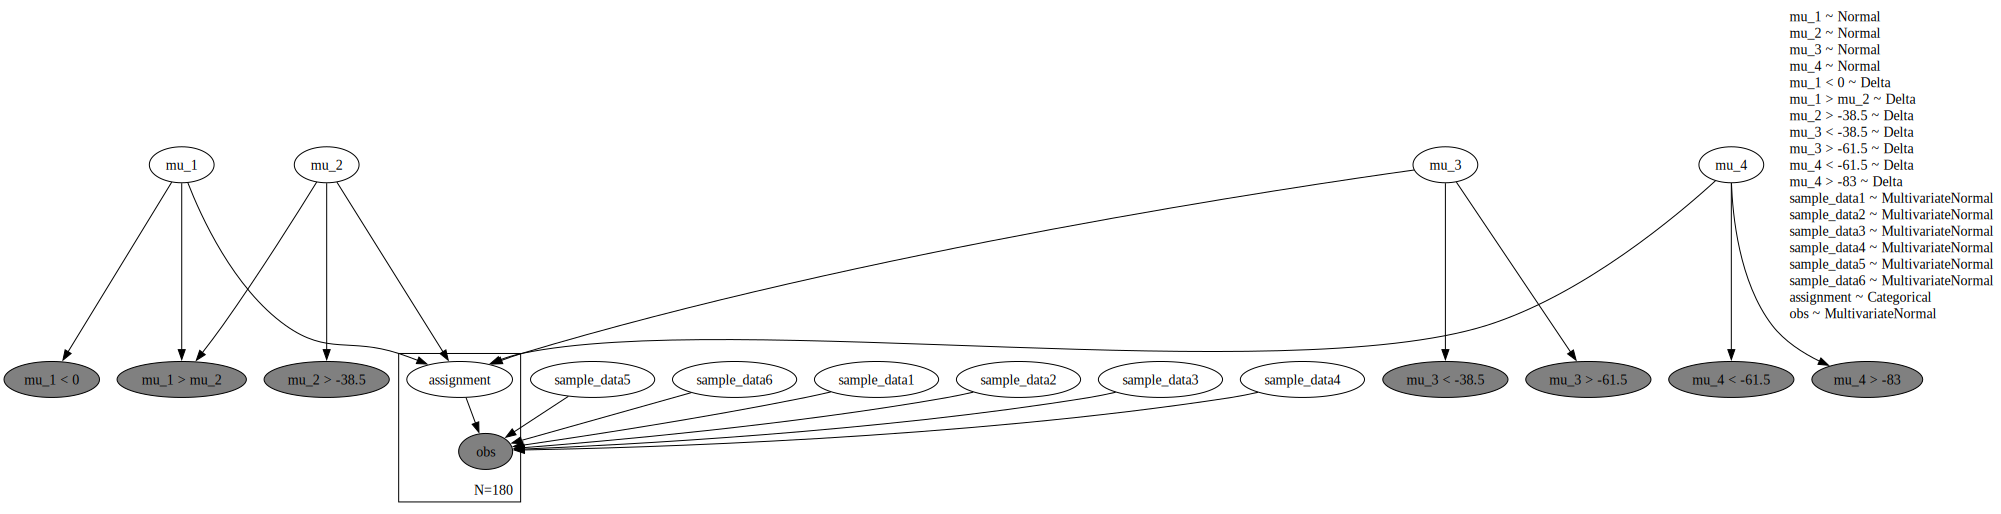

In [270]:

import torch.nn.functional as F
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(42)

@config_enumerate
def model_test(y_obs_label):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[11, 2]
    prior_mean_surface_2 = sp_coords_copy_test[14, 2]
    prior_mean_surface_3 = sp_coords_copy_test[5, 2]
    prior_mean_surface_4 = sp_coords_copy_test[0, 2]

    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_3 = pyro.sample('mu_3', dist.Normal(prior_mean_surface_3, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_4 = pyro.sample('mu_4', dist.Normal(prior_mean_surface_4, torch.tensor(0.2, dtype=torch.float64)))
    #print(mu_surface_1, mu_surface_2)
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 < 0', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 < 3.7))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_2 > -38.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > 1.775))
    pyro.sample('mu_3 < -38.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 < 1.4))
    pyro.sample('mu_3 > -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 > 0.625))
    pyro.sample('mu_4 < -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 < 0.625))
    pyro.sample('mu_4 > -83', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 > - 0.2 ))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([11]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([14]), torch.tensor([2])),
        mu_surface_2
    )
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_3
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        mu_surface_4
    )
    
    
    #print("interpolation_input",interpolation_input.surface_points.sp_coords)
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    lambda_ = 10.0
    loc_mean = torch.tensor(mean_init,dtype=torch.float64)
    loc_cov =  torch.tensor(cov_init, dtype=torch.float64)
    class_label = F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    sample =[]
    for i in range(loc_mean.shape[0]):
        sample_data = pyro.sample("sample_data"+str(i+1), dist.MultivariateNormal(loc=loc_mean[i],covariance_matrix=loc_cov[i]))
        sample.append(sample_data)
    sample_tesnor = torch.stack(sample, dim=0)
    
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(class_label))
        #print("mean\n", mean[assignment])
        #obs = pyro.sample("obs", dist.Normal(custom_grid_values, 0.5 ), obs=y_obs_label.reshape(-1))
        #obs = pyro.sample("obs", dist.Normal(sample[assignment], 0.1 ), obs=y_obs_label.reshape(-1))
        #print(sample_tesnor[assignment].shape, loc_cov[assignment].shape, y_obs_label.shape)
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=sample_tesnor[assignment],covariance_matrix=loc_cov[assignment]), obs=y_obs_label)
        #obs = pyro.sample("obs", dist.Normal(mean[assignment],  sigma[assignment]), obs=y_obs_label.reshape(-1))
    #return obs
dependencies = get_dependencies(model_test, model_args=(normalised_hsi,))
pyro.render_model(model_test, model_args=(normalised_hsi,),render_distributions=True)

In [271]:
print(normalised_data.shape)
#model_test(normalised_hsi)

(180, 208)


Condition number: 1553.975019641039.
Condition number: 1533.3188488363767.
Condition number: 1534.4533739371225.
Condition number: 1585.8978971270647.
Condition number: 1535.9926351780348.
Condition number: 1545.4795285765185.
Condition number: 1555.5677260034518.


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


KeyboardInterrupt: 

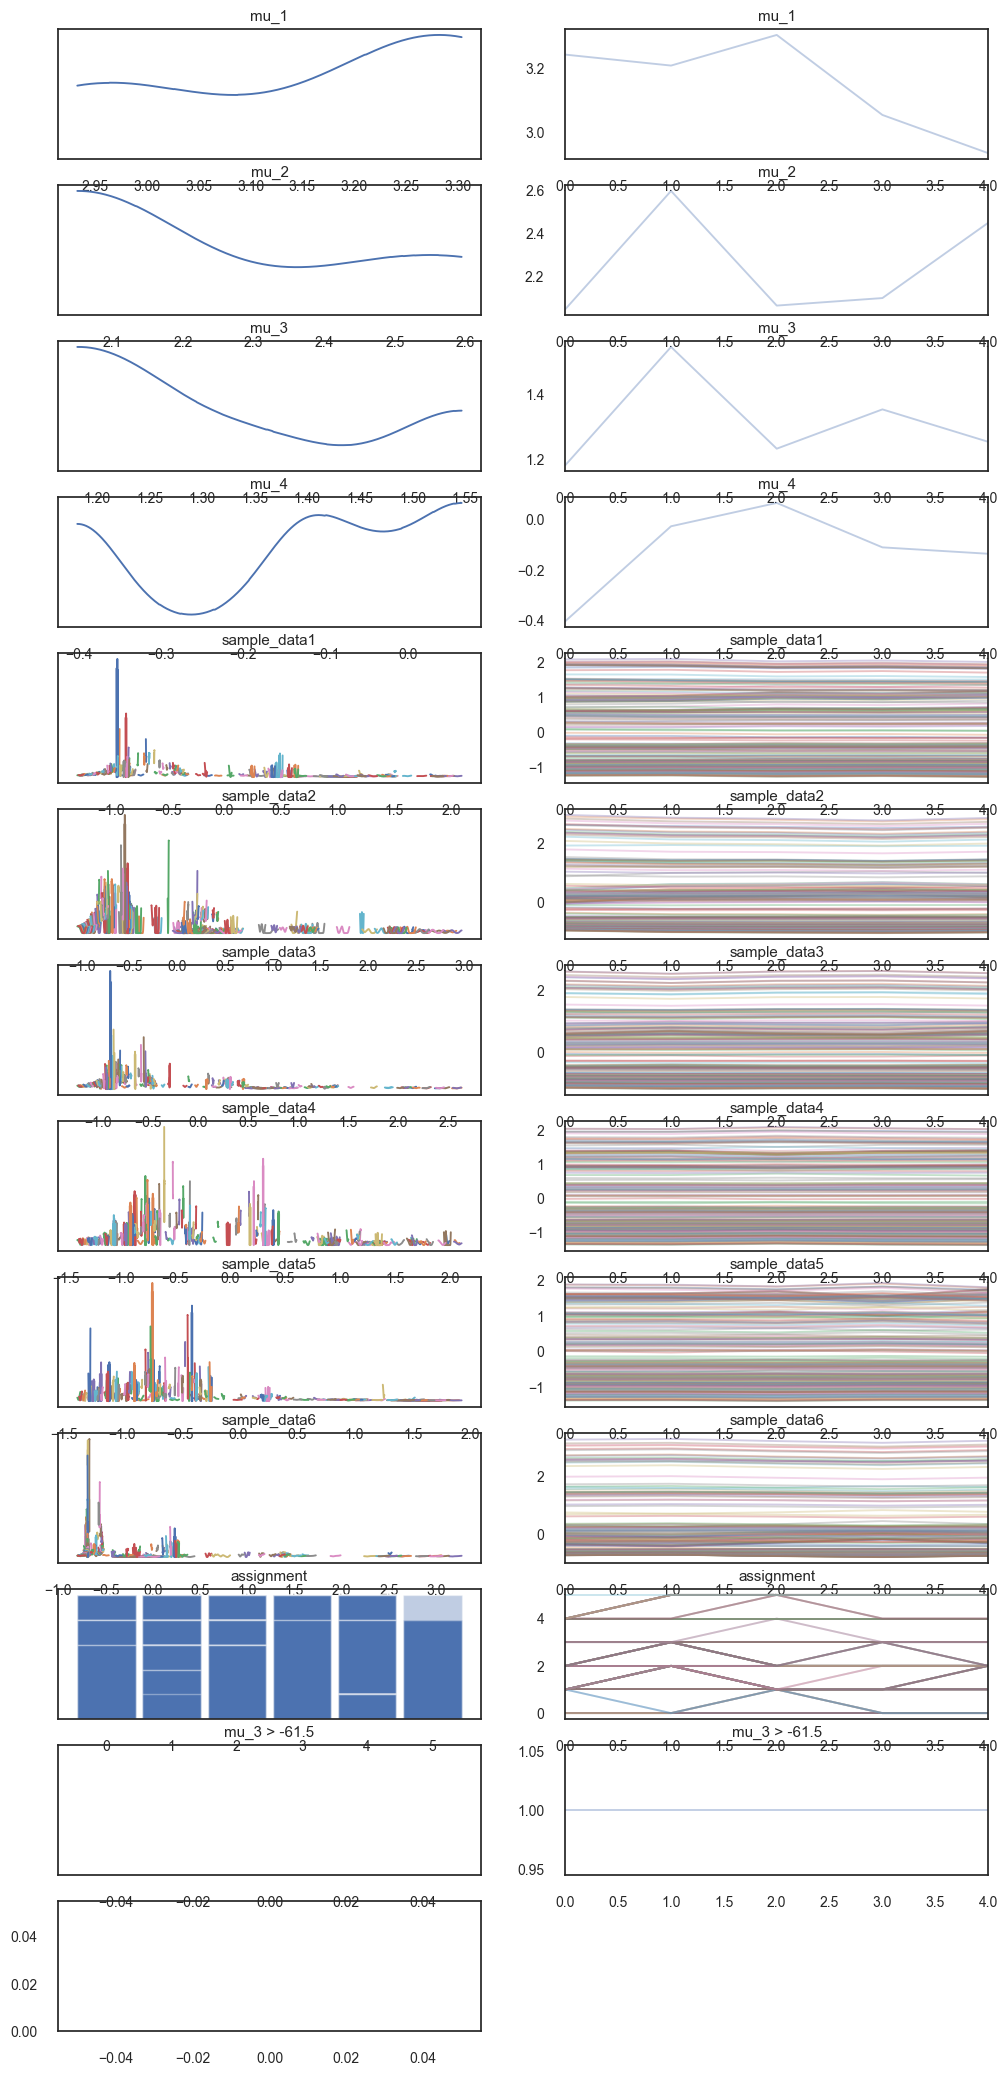

In [273]:
pyro.set_rng_seed(42)

prior = Predictive(model_test, num_samples=5)(normalised_hsi)

# Key to avoid
avoid_key = ['mu_1 < 0','mu_1 > mu_2','mu_2 > -38.5', 'mu_3 < -38.5','mu_3 > -61.4','mu_4 < -61.5', 'mu_4 > -83']

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key not in avoid_key)


data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [ ]:
pyro.set_rng_seed(42)
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
#initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, disable_validation=False)
mcmc.run(normalised_hsi)

In [ ]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(normalised_hsi)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [ ]:
posterior_samples

In [ ]:
mu_1_mean = posterior_samples["mu_1"].mean()
mu_2_mean = posterior_samples["mu_2"].mean()
mu_3_mean = posterior_samples["mu_3"].mean()
mu_4_mean = posterior_samples["mu_4"].mean()

In [ ]:
# loc_mean_posterior, loc_cov_posterior =[], []
# for key, values in posterior_samples.items():
#     print(key)
#     if key == "sample_data":
#         mean = values.mean(dim=0)
#         cov = values.std(dim=0)
#         print("mean\n",mean)
#         print("cov\n", cov)
#         loc_mean_posterior.append(mean.detach().numpy())
#         loc_cov_posterior.append(cov.detach().numpy())
#     elif key == "sigma_data":
#         print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
#     else:
#         print("mean\n",values.mean(), "\nstd\n", values.std())

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_3'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_4'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
# # Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([11]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([14]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        posterior_samples["mu_3"].mean()
    )
interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        posterior_samples["mu_4"].mean()
    )
    
#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [ ]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

In [ ]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

In [ ]:
geo_model_test_post = gp.create_geomodel(
    project_name='Gempy_abc_Test_post',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=7,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test_post,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test_post,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test_post.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([sp_cord[0,2], -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, sp_cord[5,2], -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, sp_cord[14,2], -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, sp_cord[11,2], -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element6)

geo_model_test_post.structural_frame.structural_groups[0].elements[0], geo_model_test_post.structural_frame.structural_groups[0].elements[1],\
geo_model_test_post.structural_frame.structural_groups[0].elements[2], geo_model_test_post.structural_frame.structural_groups[0].elements[3],\
geo_model_test_post.structural_frame.structural_groups[0].elements[4], geo_model_test_post.structural_frame.structural_groups[0].elements[5] = \
geo_model_test_post.structural_frame.structural_groups[0].elements[1], geo_model_test_post.structural_frame.structural_groups[0].elements[0],\
geo_model_test_post.structural_frame.structural_groups[0].elements[3], geo_model_test_post.structural_frame.structural_groups[0].elements[2],\
geo_model_test_post.structural_frame.structural_groups[0].elements[5], geo_model_test_post.structural_frame.structural_groups[0].elements[4]  


gp.set_custom_grid(geo_model_test_post.grid, xyz_coord=xyz_coord)
gp.compute_model(geo_model_test_post)
gpv.plot_2d(geo_model_test_post, cell_number=5, legend='force')


In [ ]:
custom_grid_values_post = geo_model_test_post.solutions.octrees_output[0].last_output_center.custom_grid_values

In [ ]:
custom_grid_values_post

In [ ]:
y_obs_label

In [ ]:
torch.sum(torch.tensor(custom_grid_values_post, dtype=torch.float64) != y_obs_label)/ len(y_obs_label)